In [95]:
import cv2
import os
import mediapipe as mp
import gc
from tqdm import *
import torch
from torch_geometric.data import DataLoader
import torch_geometric
#import torch.nn as nn
from mediapipe_transform import image_to_graph

from utils import *


# Load image
print(os.listdir())
path = os.path.expanduser('./ASL_Data/asl_alphabet_train/asl_alphabet_train/B/B9.jpg')
image = cv2.imread(path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Initialize MediaPipe Hands
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=True, max_num_hands=1, min_detection_confidence=0.3)

# Process image
results = hands.process(image_rgb)

# Draw results
if results.multi_hand_landmarks:
    print(f"Detected {len(results.multi_hand_landmarks)} hand(s).")
    for hand_landmarks in results.multi_hand_landmarks:
        mp.solutions.drawing_utils.draw_landmarks(
            image, hand_landmarks, mp_hands.HAND_CONNECTIONS)
else:
    print("No hands detected.")

# Show image
#cv2.imshow("Hand Detection", image)
#cv2.waitKey(0)
#cv2.destroyAllWindows()

['.DS_Store', 'models.py', 'valid_ASL_data.pt', 'mediapipe_transfer.ipynb', 'testing.ipynb', '__pycache__', 'utils.py', 'mediapipe_transfer.py', '.git', '.vscode', 'graph_data_loading.py', 'mediapipe_transform.py', 'ASL_Data']
Detected 1 hand(s).


I0000 00:00:1747272289.016389       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M3 Pro


In [96]:
import pandas as pd
from collections import defaultdict
from mediapipe.framework.formats import landmark_pb2

hand_map = defaultdict(list)
for start_idx, end_idx in mp.solutions.hands.HAND_CONNECTIONS:
        hand_map[start_idx].append(end_idx)
        hand_map[end_idx].append(start_idx) 

def hand_connections_and_landmarks(results: landmark_pb2.NormalizedLandmarkList, connection_map: defaultdict) -> pd.DataFrame:
    # Build landmark rows with connected landmark indices
    landmark_rows = []
    for hand_idx, hand_landmarks in enumerate(results.multi_hand_landmarks):
        for i, landmark in enumerate(hand_landmarks.landmark):
            landmark_rows.append({
                'hand_index': hand_idx,
                'landmark_index': i,
                'x': landmark.x,
                'y': 1 - landmark.y, # Invert y-axis for image coordinates
                'z': landmark.z,
                'connected_to': connection_map[i] 
            })
    return(pd.DataFrame(landmark_rows))

landmark_df = hand_connections_and_landmarks(results, hand_map)
print(landmark_df)

    hand_index  landmark_index         x         y             z connected_to
0            0               0  0.542424  0.056221  7.720606e-07   [5, 17, 1]
1            0               1  0.678073  0.113741 -8.402520e-02       [0, 2]
2            0               2  0.760190  0.246924 -1.167022e-01       [1, 3]
3            0               3  0.703754  0.356262 -1.400449e-01       [4, 2]
4            0               4  0.596519  0.371651 -1.623484e-01          [3]
5            0               5  0.691353  0.438471 -5.630908e-02    [0, 6, 9]
6            0               6  0.688316  0.589617 -9.876654e-02       [5, 7]
7            0               7  0.673873  0.678728 -1.381861e-01       [6, 8]
8            0               8  0.658365  0.758907 -1.682497e-01          [7]
9            0               9  0.606306  0.452494 -4.635421e-02  [5, 10, 13]
10           0              10  0.606449  0.621111 -8.030972e-02      [9, 11]
11           0              11  0.599289  0.723272 -1.155634e-01

In [97]:
import torch
from torch_geometric.data import Data

def hand_graph(df: pd.DataFrame, label: int) -> Data:
    # Sort by landmark index to ensure node order
    df = df.sort_values('landmark_index')
    
    # Node features: x, y, z
    x = torch.tensor(df[['x', 'y', 'z']].values, dtype=torch.float)

    # Extract edges from `connected_to`
    edge_list = []
    for _, row in df.iterrows():
        src = row['landmark_index']
        for dst in row['connected_to']:
            edge_list.append((src, dst)) 

    # Ensure bidirectionality and remove duplicates
    edge_list += [(dst, src) for (src, dst) in edge_list]
    edge_list = list(set(edge_list))  # remove duplicates
    edge_index = torch.tensor(edge_list, dtype=torch.long).t().contiguous()  # [2, num_edges]

    # Label
    y = torch.tensor([label], dtype=torch.long)

    return Data(x=x, edge_index=edge_index, y=y)


In [98]:
T_label = 19
graph_for_T = hand_graph(landmark_df, label=T_label)
graph_for_T

Data(x=[21, 3], edge_index=[2, 42], y=[1])

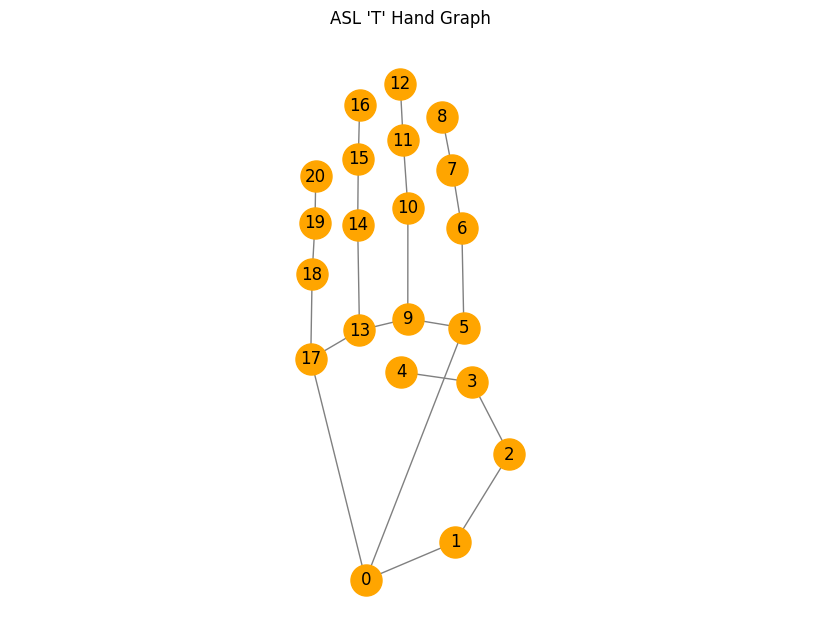

In [99]:
from torch_geometric.utils import to_networkx
import networkx as nx
import matplotlib.pyplot as plt

G = to_networkx(graph_for_T, to_undirected=True)
pos = {i: (graph_for_T.x[i][0].item(), graph_for_T.x[i][1].item()) for i in range(graph_for_T.num_nodes)}

plt.figure(figsize=(8, 6))
nx.draw(G, pos, with_labels=True, node_color='orange', edge_color='gray', node_size=500)
plt.title("ASL 'T' Hand Graph")
plt.axis('equal')
plt.show()

In [102]:
from torch_geometric.nn import GCNConv, global_mean_pool, SGConv
import torch.nn as nn
import torch.nn.functional as F

class HandGNN(torch.nn.Module):
    def __init__(self, num_classes, dropout_rate=0.2, device='cpu'):
        super().__init__()

        # Convolution dimensions
        dc1 = 256
        dc2 = dc1
        dc3 = 64
        # Linear dimensions
        dl1 = dc3

        self.conv1 = SGConv(in_channels=3, out_channels=dc1)
        self.conv2 = SGConv(in_channels=dc1, out_channels=dc2)
        self.conv3 = SGConv(in_channels=dc2, out_channels=dc3)
        
        self.bn1 = nn.BatchNorm1d(dc1)
        self.bn2 = nn.BatchNorm1d(dc2)
        self.bn3 = nn.BatchNorm1d(dc3)

        self.lin1 = nn.Linear(dc3, dl1)
        self.lin2 = nn.Linear(dl1, num_classes)
        self.drop = nn.Dropout(dropout_rate)

        self.train_loss_history = []
        self.val_loss_history = []

        self.trained_epochs = 0

        self.best_acc = 0
        self.best_model_state_dict = None

    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = F.relu(x)
        id1 = x
        x = self.conv2(x, edge_index)
        x = self.bn2(x)
        x = F.relu(x) + id1
        x = self.conv3(x, edge_index)
        x = self.bn3(x)
        x = F.relu(x)
        #x = self.drop(x)
        x = global_mean_pool(x, batch)
        id2 = x
        x = self.lin1(x)
        x = self.drop(x)
        x = F.relu(x) + id2
        x = self.lin2(x)
        
        return x 
    
    def fit(self, train_loader, val_loader, epochs: int = 50, lr: float = 1e-3):
        crit = nn.CrossEntropyLoss(reduction = 'sum')
        optimizer = torch.optim.Adam(self.parameters(), lr = lr, weight_decay = 0)
        scheduler = torch.optim.lr_scheduler.MultiplicativeLR(
            optimizer, lambda epoch: 0.99 if epoch > 20 else 0.95
        )
        
        for epoch in range(1, epochs+1):

            n_train = 0
            num_correct_train = 0
            n_val = 0
            num_correct_val = 0

            training_loss = 0
            val_loss = 0
            
            self.train()
            for data in tqdm(train_loader):
                #print(data.batch)
                optimizer.zero_grad()
                preds = self.forward(data.x, data.edge_index, data.batch)
                pred_signs = preds.argmax(dim=1) == data.y.long()
                num_correct_train += pred_signs.sum()
                loss = crit(preds, data.y.long())
                training_loss += loss.item() #/ data.num_graphs
                n_train += data.num_graphs
                loss.backward()
                optimizer.step()
            
            self.eval()
            with torch.no_grad():
                for data in tqdm(val_loader):
                    
                    preds = self.forward(data.x, data.edge_index, data.batch)
                    pred_signs = preds.argmax(dim=1) == data.y.long()
                    num_correct_val += pred_signs.sum()
                    val_loss += crit(preds, data.y.long()).item() #/ data.num_graphs
                    n_val += data.num_graphs
            
            if num_correct_val/n_val > self.best_acc:
                print('Best Model Found')
                self.best_acc = num_correct_val/n_val
                self.best_model_state_dict = self.state_dict

            print(f'Current Learning Rate: {scheduler.get_last_lr()}')
            scheduler.step(self.trained_epochs)
            self.train_loss_history.append(training_loss/n_train)
            self.val_loss_history.append(val_loss/n_val)
            self.trained_epochs += 1
            
            print(f'Epoch {epoch}:\nLoss- Train Loss: {training_loss/n_train},\nVal Loss: {val_loss/n_val},\nTrain Accuracy: {num_correct_train/n_train},\nVal Accuracy: {num_correct_val/n_val}\n')




In [103]:
data_list = torch.load('valid_ASL_data.pt')
train_data, val_data, test_data = data_split(data_list, train_prop = 0.8, val_prop = 0.1, seed = 1)

train_loader = torch_geometric.loader.DataLoader(train_data, batch_size = 256, shuffle = True)
val_loader = torch_geometric.loader.DataLoader(val_data, batch_size = 128, shuffle = True)
test_loader = torch_geometric.loader.DataLoader(test_data, batch_size = 128, shuffle = True)


In [104]:
net = HandGNN(num_classes=26)
net.fit(train_loader, val_loader, epochs = 100, lr = 1e-2)


100%|██████████| 49/49 [00:12<00:00,  4.06it/s]
/opt/anaconda3/envs/ASL_Project2/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Best Model Found
Current Learning Rate: [0.01]
Epoch 1:
Loss- Train Loss: 2.630015969514866,
Val Loss: 2.888077919921875,
Train Accuracy: 0.20773662626743317,
Val Accuracy: 0.2030400037765503



100%|██████████| 49/49 [00:11<00:00,  4.36it/s]


Best Model Found
Current Learning Rate: [0.01]
Epoch 2:
Loss- Train Loss: 2.122959530060745,
Val Loss: 2.2088536987304686,
Train Accuracy: 0.33696696162223816,
Val Accuracy: 0.3176000118255615



100%|██████████| 49/49 [00:10<00:00,  4.87it/s]


Best Model Found
Current Learning Rate: [0.0095]
Epoch 3:
Loss- Train Loss: 1.8833056379007391,
Val Loss: 1.9740605737304688,
Train Accuracy: 0.41035282611846924,
Val Accuracy: 0.3558399975299835



100%|██████████| 49/49 [00:11<00:00,  4.40it/s]


Current Learning Rate: [0.009025]
Epoch 4:
Loss- Train Loss: 1.7073862986980852,
Val Loss: 2.6094635986328125,
Train Accuracy: 0.4572365880012512,
Val Accuracy: 0.31376001238822937



100%|██████████| 49/49 [00:10<00:00,  4.48it/s]


Current Learning Rate: [0.00857375]
Epoch 5:
Loss- Train Loss: 1.5636102511736094,
Val Loss: 2.3482004443359377,
Train Accuracy: 0.49987998604774475,
Val Accuracy: 0.3400000035762787



100%|██████████| 49/49 [00:11<00:00,  4.43it/s]


Best Model Found
Current Learning Rate: [0.0081450625]
Epoch 6:
Loss- Train Loss: 1.4375062717114537,
Val Loss: 1.6411009692382812,
Train Accuracy: 0.5374829769134521,
Val Accuracy: 0.4846400022506714



100%|██████████| 49/49 [00:10<00:00,  4.67it/s]


Current Learning Rate: [0.007737809374999999]
Epoch 7:
Loss- Train Loss: 1.3456805475102072,
Val Loss: 1.6977241650390624,
Train Accuracy: 0.5690455436706543,
Val Accuracy: 0.476639986038208



100%|██████████| 49/49 [00:10<00:00,  4.53it/s]


Current Learning Rate: [0.007350918906249998]
Epoch 8:
Loss- Train Loss: 1.27076940508268,
Val Loss: 2.039818837890625,
Train Accuracy: 0.593127429485321,
Val Accuracy: 0.450080007314682



100%|██████████| 49/49 [00:10<00:00,  4.60it/s]


Best Model Found
Current Learning Rate: [0.006983372960937498]
Epoch 9:
Loss- Train Loss: 1.2090104946432825,
Val Loss: 1.5122695141601563,
Train Accuracy: 0.6130290627479553,
Val Accuracy: 0.5366399884223938



100%|██████████| 49/49 [00:10<00:00,  4.66it/s]


Current Learning Rate: [0.006634204312890623]
Epoch 10:
Loss- Train Loss: 1.1414234523954787,
Val Loss: 2.3930445068359374,
Train Accuracy: 0.633830726146698,
Val Accuracy: 0.41631999611854553



100%|██████████| 49/49 [00:12<00:00,  3.99it/s]


Best Model Found
Current Learning Rate: [0.006302494097246091]
Epoch 11:
Loss- Train Loss: 1.0719189424497222,
Val Loss: 1.2771418811035156,
Train Accuracy: 0.6562125086784363,
Val Accuracy: 0.5896000266075134



100%|██████████| 49/49 [00:19<00:00,  2.56it/s]


Current Learning Rate: [0.005987369392383786]
Epoch 12:
Loss- Train Loss: 1.0300622081382722,
Val Loss: 2.437805173339844,
Train Accuracy: 0.6705736517906189,
Val Accuracy: 0.4665600061416626



100%|██████████| 49/49 [00:12<00:00,  3.98it/s]


Best Model Found
Current Learning Rate: [0.005688000922764597]
Epoch 13:
Loss- Train Loss: 0.9886113035649298,
Val Loss: 1.267363194580078,
Train Accuracy: 0.6844547390937805,
Val Accuracy: 0.608959972858429



100%|██████████| 49/49 [00:11<00:00,  4.20it/s]


Current Learning Rate: [0.005403600876626367]
Epoch 14:
Loss- Train Loss: 0.9362626379800325,
Val Loss: 1.41586134765625,
Train Accuracy: 0.7004160284996033,
Val Accuracy: 0.592960000038147



100%|██████████| 49/49 [00:10<00:00,  4.69it/s]


Best Model Found
Current Learning Rate: [0.005133420832795048]
Epoch 15:
Loss- Train Loss: 0.9003205334856964,
Val Loss: 1.027263525390625,
Train Accuracy: 0.7110368609428406,
Val Accuracy: 0.6736000180244446



100%|██████████| 49/49 [00:09<00:00,  5.12it/s]


Current Learning Rate: [0.0048767497911552955]
Epoch 16:
Loss- Train Loss: 0.8592746088205123,
Val Loss: 1.248594510498047,
Train Accuracy: 0.7269181609153748,
Val Accuracy: 0.6662399768829346



100%|██████████| 49/49 [00:11<00:00,  4.18it/s]


Best Model Found
Current Learning Rate: [0.00463291230159753]
Epoch 17:
Loss- Train Loss: 0.8290729914887331,
Val Loss: 0.8959873937988281,
Train Accuracy: 0.7346587777137756,
Val Accuracy: 0.7115200161933899



100%|██████████| 49/49 [00:11<00:00,  4.11it/s]


Best Model Found
Current Learning Rate: [0.0044012666865176535]
Epoch 18:
Loss- Train Loss: 0.7974607374717907,
Val Loss: 0.78020638671875,
Train Accuracy: 0.7474597692489624,
Val Accuracy: 0.7513599991798401



100%|██████████| 49/49 [00:12<00:00,  3.93it/s]


Current Learning Rate: [0.004181203352191771]
Epoch 19:
Loss- Train Loss: 0.777966698395442,
Val Loss: 0.8410184680175782,
Train Accuracy: 0.7519601583480835,
Val Accuracy: 0.7388799786567688



100%|██████████| 49/49 [00:14<00:00,  3.39it/s]


Best Model Found
Current Learning Rate: [0.003972143184582182]
Epoch 20:
Loss- Train Loss: 0.7339427219942977,
Val Loss: 0.7251514373779296,
Train Accuracy: 0.768641471862793,
Val Accuracy: 0.7804800271987915



100%|██████████| 49/49 [00:10<00:00,  4.86it/s]


Current Learning Rate: [0.0037735360253530726]
Epoch 21:
Loss- Train Loss: 0.710122395118758,
Val Loss: 0.878093076171875,
Train Accuracy: 0.7737619280815125,
Val Accuracy: 0.7396799921989441



100%|██████████| 49/49 [00:10<00:00,  4.66it/s]


Best Model Found
Current Learning Rate: [0.0035848592240854188]
Epoch 22:
Loss- Train Loss: 0.692217107791597,
Val Loss: 0.6311342596435547,
Train Accuracy: 0.7810424566268921,
Val Accuracy: 0.8028799891471863



100%|██████████| 49/49 [00:09<00:00,  4.91it/s]


Best Model Found
Current Learning Rate: [0.0035490106318445645]
Epoch 23:
Loss- Train Loss: 0.6791342918334345,
Val Loss: 0.6145082019042969,
Train Accuracy: 0.7849227786064148,
Val Accuracy: 0.8113600015640259



100%|██████████| 49/49 [00:08<00:00,  5.57it/s]


Current Learning Rate: [0.0035135205255261187]
Epoch 24:
Loss- Train Loss: 0.6491651428977111,
Val Loss: 0.671632958984375,
Train Accuracy: 0.7963436841964722,
Val Accuracy: 0.7934399843215942



100%|██████████| 49/49 [00:06<00:00,  7.88it/s]


Current Learning Rate: [0.0034783853202708576]
Epoch 25:
Loss- Train Loss: 0.633685254833204,
Val Loss: 0.7729313018798828,
Train Accuracy: 0.801344096660614,
Val Accuracy: 0.7579200267791748



100%|██████████| 49/49 [00:09<00:00,  5.07it/s]


Current Learning Rate: [0.003443601467068149]
Epoch 26:
Loss- Train Loss: 0.6284523529857242,
Val Loss: 0.7141591278076171,
Train Accuracy: 0.8006840348243713,
Val Accuracy: 0.7820799946784973



100%|██████████| 49/49 [00:08<00:00,  5.68it/s]


Current Learning Rate: [0.0034091654523974676]
Epoch 27:
Loss- Train Loss: 0.6072681677876516,
Val Loss: 0.6965854309082031,
Train Accuracy: 0.8073245882987976,
Val Accuracy: 0.7852799892425537



100%|██████████| 49/49 [00:07<00:00,  6.14it/s]


Current Learning Rate: [0.003375073797873493]
Epoch 28:
Loss- Train Loss: 0.5925507648094758,
Val Loss: 0.7464616723632812,
Train Accuracy: 0.813585102558136,
Val Accuracy: 0.76528000831604



100%|██████████| 49/49 [00:08<00:00,  5.95it/s]


Best Model Found
Current Learning Rate: [0.003341323059894758]
Epoch 29:
Loss- Train Loss: 0.5727341953530599,
Val Loss: 0.6009997283935546,
Train Accuracy: 0.8196855783462524,
Val Accuracy: 0.8180800080299377



100%|██████████| 49/49 [00:06<00:00,  7.29it/s]


Current Learning Rate: [0.0033079098292958108]
Epoch 30:
Loss- Train Loss: 0.5744750498008591,
Val Loss: 0.7117372814941406,
Train Accuracy: 0.8174654245376587,
Val Accuracy: 0.7777600288391113



100%|██████████| 49/49 [00:08<00:00,  6.02it/s]


Current Learning Rate: [0.0032748307310028527]
Epoch 31:
Loss- Train Loss: 0.563814824042735,
Val Loss: 0.8236581994628907,
Train Accuracy: 0.820945680141449,
Val Accuracy: 0.748960018157959



100%|██████████| 49/49 [00:09<00:00,  5.37it/s]


Current Learning Rate: [0.003242082423692824]
Epoch 32:
Loss- Train Loss: 0.5425148336818117,
Val Loss: 0.6682453314208985,
Train Accuracy: 0.8296263813972473,
Val Accuracy: 0.8047999739646912



100%|██████████| 49/49 [00:12<00:00,  4.00it/s]


Current Learning Rate: [0.003209661599455896]
Epoch 33:
Loss- Train Loss: 0.5233810636003224,
Val Loss: 0.6760726733398438,
Train Accuracy: 0.8353268504142761,
Val Accuracy: 0.7968000173568726



100%|██████████| 49/49 [00:09<00:00,  5.32it/s]


Current Learning Rate: [0.003177564983461337]
Epoch 34:
Loss- Train Loss: 0.5360415062147843,
Val Loss: 1.020308076171875,
Train Accuracy: 0.8297063708305359,
Val Accuracy: 0.751039981842041



100%|██████████| 49/49 [00:08<00:00,  5.74it/s]


Current Learning Rate: [0.0031457893336267234]
Epoch 35:
Loss- Train Loss: 0.4993094686832759,
Val Loss: 0.6212719323730469,
Train Accuracy: 0.8408272862434387,
Val Accuracy: 0.8113600015640259



100%|██████████| 49/49 [00:09<00:00,  5.23it/s]


Current Learning Rate: [0.003114331440290456]
Epoch 36:
Loss- Train Loss: 0.4855958045277655,
Val Loss: 0.5862590924072265,
Train Accuracy: 0.8481078743934631,
Val Accuracy: 0.8054400086402893



100%|██████████| 49/49 [00:10<00:00,  4.55it/s]


Best Model Found
Current Learning Rate: [0.0030831881258875514]
Epoch 37:
Loss- Train Loss: 0.48618084171770365,
Val Loss: 0.5182716412353515,
Train Accuracy: 0.8465477228164673,
Val Accuracy: 0.8412799835205078



100%|██████████| 49/49 [00:10<00:00,  4.81it/s]


Current Learning Rate: [0.003052356244628676]
Epoch 38:
Loss- Train Loss: 0.47799158908909,
Val Loss: 0.5967708026123046,
Train Accuracy: 0.8478278517723083,
Val Accuracy: 0.8182399868965149



100%|██████████| 49/49 [00:10<00:00,  4.46it/s]


Current Learning Rate: [0.003021832682182389]
Epoch 39:
Loss- Train Loss: 0.48253947405331,
Val Loss: 0.6736244830322266,
Train Accuracy: 0.8477078080177307,
Val Accuracy: 0.7900800108909607



100%|██████████| 49/49 [00:09<00:00,  5.43it/s]


Best Model Found
Current Learning Rate: [0.0029916143553605653]
Epoch 40:
Loss- Train Loss: 0.45597589114197007,
Val Loss: 0.4032903338623047,
Train Accuracy: 0.8567085266113281,
Val Accuracy: 0.8855999708175659



100%|██████████| 49/49 [00:10<00:00,  4.88it/s]


Current Learning Rate: [0.0029616982118069596]
Epoch 41:
Loss- Train Loss: 0.45218023768195403,
Val Loss: 0.5752400915527344,
Train Accuracy: 0.8582486510276794,
Val Accuracy: 0.8212800025939941



100%|██████████| 49/49 [00:10<00:00,  4.77it/s]


Current Learning Rate: [0.00293208122968889]
Epoch 42:
Loss- Train Loss: 0.4399415617495005,
Val Loss: 0.49174352783203124,
Train Accuracy: 0.8620489835739136,
Val Accuracy: 0.8548799753189087



100%|██████████| 49/49 [00:09<00:00,  5.00it/s]


Current Learning Rate: [0.002902760417392001]
Epoch 43:
Loss- Train Loss: 0.43978758557947817,
Val Loss: 0.43892161560058596,
Train Accuracy: 0.8617289662361145,
Val Accuracy: 0.869920015335083



100%|██████████| 49/49 [00:09<00:00,  5.22it/s]


Current Learning Rate: [0.002873732813218081]
Epoch 44:
Loss- Train Loss: 0.4197383149355562,
Val Loss: 0.43848074920654295,
Train Accuracy: 0.8700096011161804,
Val Accuracy: 0.8672000169754028



100%|██████████| 49/49 [00:11<00:00,  4.26it/s]


Current Learning Rate: [0.0028449954850859]
Epoch 45:
Loss- Train Loss: 0.4137668859120302,
Val Loss: 0.4915217901611328,
Train Accuracy: 0.870789647102356,
Val Accuracy: 0.8492799997329712



100%|██████████| 49/49 [00:09<00:00,  4.94it/s]


Current Learning Rate: [0.002816545530235041]
Epoch 46:
Loss- Train Loss: 0.40829851272745377,
Val Loss: 0.6456801782226562,
Train Accuracy: 0.8719297647476196,
Val Accuracy: 0.8055999875068665



100%|██████████| 49/49 [00:09<00:00,  4.98it/s]


Current Learning Rate: [0.0027883800749326903]
Epoch 47:
Loss- Train Loss: 0.39537640504526494,
Val Loss: 0.4272441470336914,
Train Accuracy: 0.8755500316619873,
Val Accuracy: 0.8715199828147888



100%|██████████| 49/49 [00:11<00:00,  4.32it/s]


Current Learning Rate: [0.0027604962741833634]
Epoch 48:
Loss- Train Loss: 0.3958107642874125,
Val Loss: 0.4278043142700195,
Train Accuracy: 0.8747699856758118,
Val Accuracy: 0.8652799725532532



100%|██████████| 49/49 [00:09<00:00,  5.32it/s]


Current Learning Rate: [0.0027328913114415296]
Epoch 49:
Loss- Train Loss: 0.3813526036977978,
Val Loss: 0.41768207244873046,
Train Accuracy: 0.8820105791091919,
Val Accuracy: 0.8804799914360046



100%|██████████| 49/49 [00:09<00:00,  5.27it/s]


Best Model Found
Current Learning Rate: [0.0027055623983271142]
Epoch 50:
Loss- Train Loss: 0.3925894951570491,
Val Loss: 0.35356184967041016,
Train Accuracy: 0.8782302737236023,
Val Accuracy: 0.8931199908256531



100%|██████████| 49/49 [00:10<00:00,  4.68it/s]


Current Learning Rate: [0.002678506774343843]
Epoch 51:
Loss- Train Loss: 0.37579689999467536,
Val Loss: 0.4020134808349609,
Train Accuracy: 0.8832906484603882,
Val Accuracy: 0.8876799941062927



100%|██████████| 49/49 [00:08<00:00,  5.63it/s]


Current Learning Rate: [0.0026517217066004046]
Epoch 52:
Loss- Train Loss: 0.3680606452605564,
Val Loss: 0.42959546783447267,
Train Accuracy: 0.8851908445358276,
Val Accuracy: 0.872160017490387



100%|██████████| 49/49 [00:10<00:00,  4.53it/s]


Current Learning Rate: [0.0026252044895344003]
Epoch 53:
Loss- Train Loss: 0.3620985677236747,
Val Loss: 0.44917599060058594,
Train Accuracy: 0.8853908181190491,
Val Accuracy: 0.8654400110244751



100%|██████████| 49/49 [00:09<00:00,  4.91it/s]


Best Model Found
Current Learning Rate: [0.0025989524446390563]
Epoch 54:
Loss- Train Loss: 0.35579882691274484,
Val Loss: 0.3532329037475586,
Train Accuracy: 0.8886510729789734,
Val Accuracy: 0.9014400243759155



100%|██████████| 49/49 [00:11<00:00,  4.27it/s]


Current Learning Rate: [0.002572962920192666]
Epoch 55:
Loss- Train Loss: 0.35434984105979456,
Val Loss: 0.4904924230957031,
Train Accuracy: 0.8899511694908142,
Val Accuracy: 0.8548799753189087



100%|██████████| 49/49 [00:16<00:00,  3.00it/s]


Current Learning Rate: [0.002547233290990739]
Epoch 56:
Loss- Train Loss: 0.35046267637263034,
Val Loss: 0.44578423156738284,
Train Accuracy: 0.8905512690544128,
Val Accuracy: 0.8695999979972839



100%|██████████| 49/49 [00:10<00:00,  4.50it/s]


Current Learning Rate: [0.0025217609580808317]
Epoch 57:
Loss- Train Loss: 0.33875769639513054,
Val Loss: 0.3646233670043945,
Train Accuracy: 0.8956716656684875,
Val Accuracy: 0.8952000141143799



100%|██████████| 49/49 [00:08<00:00,  6.04it/s]


Best Model Found
Current Learning Rate: [0.0024965433485000235]
Epoch 58:
Loss- Train Loss: 0.3422639681841051,
Val Loss: 0.3514865167236328,
Train Accuracy: 0.89313143491745,
Val Accuracy: 0.9049599766731262



100%|██████████| 49/49 [00:09<00:00,  4.99it/s]


Current Learning Rate: [0.0024715779150150234]
Epoch 59:
Loss- Train Loss: 0.33630807301131943,
Val Loss: 0.738810396118164,
Train Accuracy: 0.896131694316864,
Val Accuracy: 0.7891200184822083



100%|██████████| 49/49 [00:09<00:00,  4.94it/s]


Current Learning Rate: [0.002446862135864873]
Epoch 60:
Loss- Train Loss: 0.3263097920315925,
Val Loss: 0.39106124450683594,
Train Accuracy: 0.8987919092178345,
Val Accuracy: 0.8865600228309631



100%|██████████| 49/49 [00:09<00:00,  5.14it/s]


Current Learning Rate: [0.002422393514506224]
Epoch 61:
Loss- Train Loss: 0.3205306899100268,
Val Loss: 0.4431734945678711,
Train Accuracy: 0.9002920389175415,
Val Accuracy: 0.8707200288772583



100%|██████████| 49/49 [00:04<00:00, 10.08it/s]


Current Learning Rate: [0.002398169579361162]
Epoch 62:
Loss- Train Loss: 0.31764899300464544,
Val Loss: 0.3809962664794922,
Train Accuracy: 0.9001920223236084,
Val Accuracy: 0.8952000141143799



100%|██████████| 49/49 [00:04<00:00, 11.63it/s]


Current Learning Rate: [0.00237418788356755]
Epoch 63:
Loss- Train Loss: 0.31386296246869916,
Val Loss: 0.6310540942382813,
Train Accuracy: 0.9028122425079346,
Val Accuracy: 0.8193600177764893



100%|██████████| 49/49 [00:04<00:00, 11.25it/s]


Current Learning Rate: [0.0023504460047318746]
Epoch 64:
Loss- Train Loss: 0.3232753362853257,
Val Loss: 0.3542519888305664,
Train Accuracy: 0.897851824760437,
Val Accuracy: 0.8948799967765808



100%|██████████| 49/49 [00:04<00:00, 11.06it/s]


Best Model Found
Current Learning Rate: [0.0023269415446845556]
Epoch 65:
Loss- Train Loss: 0.31011180303909175,
Val Loss: 0.3115751773071289,
Train Accuracy: 0.903712272644043,
Val Accuracy: 0.9116799831390381



100%|██████████| 49/49 [00:04<00:00, 11.60it/s]


Current Learning Rate: [0.00230367212923771]
Epoch 66:
Loss- Train Loss: 0.3082267372252817,
Val Loss: 0.33731098541259763,
Train Accuracy: 0.9043323397636414,
Val Accuracy: 0.9043200016021729



100%|██████████| 49/49 [00:04<00:00, 11.34it/s]


Current Learning Rate: [0.002280635407945333]
Epoch 67:
Loss- Train Loss: 0.29769611614247743,
Val Loss: 0.3240605920410156,
Train Accuracy: 0.9075525999069214,
Val Accuracy: 0.9107199907302856



100%|██████████| 49/49 [00:04<00:00, 10.14it/s]


Current Learning Rate: [0.0022578290538658795]
Epoch 68:
Loss- Train Loss: 0.29001909416669347,
Val Loss: 0.3802545034790039,
Train Accuracy: 0.9099528193473816,
Val Accuracy: 0.8937600255012512



100%|██████████| 49/49 [00:04<00:00, 10.82it/s]


Current Learning Rate: [0.0022352507633272207]
Epoch 69:
Loss- Train Loss: 0.2821023461341629,
Val Loss: 0.35718533966064453,
Train Accuracy: 0.9143731594085693,
Val Accuracy: 0.893280029296875



100%|██████████| 49/49 [00:04<00:00, 11.46it/s]


Current Learning Rate: [0.0022128982556939487]
Epoch 70:
Loss- Train Loss: 0.2788024054345002,
Val Loss: 0.3393341683959961,
Train Accuracy: 0.9143731594085693,
Val Accuracy: 0.8977599740028381



100%|██████████| 49/49 [00:04<00:00, 10.68it/s]


Best Model Found
Current Learning Rate: [0.002190769273137009]
Epoch 71:
Loss- Train Loss: 0.2923303490133703,
Val Loss: 0.3032618505859375,
Train Accuracy: 0.9090527296066284,
Val Accuracy: 0.9223999977111816



100%|██████████| 49/49 [00:04<00:00, 10.36it/s]


Current Learning Rate: [0.002168861580405639]
Epoch 72:
Loss- Train Loss: 0.27695026591507205,
Val Loss: 0.2900521270751953,
Train Accuracy: 0.9132330417633057,
Val Accuracy: 0.9200000166893005



100%|██████████| 49/49 [00:04<00:00, 10.48it/s]


Current Learning Rate: [0.0021471729646015828]
Epoch 73:
Loss- Train Loss: 0.27471057574590096,
Val Loss: 0.34567739440917966,
Train Accuracy: 0.9145331382751465,
Val Accuracy: 0.8952000141143799



100%|██████████| 49/49 [00:03<00:00, 12.35it/s]


Current Learning Rate: [0.002125701234955567]
Epoch 74:
Loss- Train Loss: 0.26821432488280705,
Val Loss: 0.44671238220214843,
Train Accuracy: 0.9166933298110962,
Val Accuracy: 0.8831999897956848



100%|██████████| 49/49 [00:04<00:00, 10.57it/s]


Current Learning Rate: [0.0021044442226060113]
Epoch 75:
Loss- Train Loss: 0.26967897414398134,
Val Loss: 0.3618617636108398,
Train Accuracy: 0.9163132905960083,
Val Accuracy: 0.8944000005722046



100%|██████████| 49/49 [00:04<00:00, 11.34it/s]


Current Learning Rate: [0.0020833997803799513]
Epoch 76:
Loss- Train Loss: 0.2643250803325985,
Val Loss: 0.36640832153320313,
Train Accuracy: 0.9191935062408447,
Val Accuracy: 0.8876799941062927



100%|██████████| 49/49 [00:04<00:00, 10.92it/s]


Current Learning Rate: [0.0020625657825761516]
Epoch 77:
Loss- Train Loss: 0.2634756317309584,
Val Loss: 0.3204252639770508,
Train Accuracy: 0.9186334609985352,
Val Accuracy: 0.9064000248908997



100%|██████████| 49/49 [00:04<00:00, 11.28it/s]


Best Model Found
Current Learning Rate: [0.00204194012475039]
Epoch 78:
Loss- Train Loss: 0.2579784686302736,
Val Loss: 0.28102799560546876,
Train Accuracy: 0.9214137196540833,
Val Accuracy: 0.9257599711418152



100%|██████████| 49/49 [00:04<00:00, 11.67it/s]


Current Learning Rate: [0.0020215207235028862]
Epoch 79:
Loss- Train Loss: 0.25225998632563945,
Val Loss: 0.30561295501708985,
Train Accuracy: 0.9226738214492798,
Val Accuracy: 0.9177600145339966



100%|██████████| 49/49 [00:04<00:00, 11.83it/s]


Current Learning Rate: [0.0020013055162678576]
Epoch 80:
Loss- Train Loss: 0.2546818797536274,
Val Loss: 0.2746831332397461,
Train Accuracy: 0.9208136796951294,
Val Accuracy: 0.9215999841690063



100%|██████████| 49/49 [00:04<00:00, 11.67it/s]


Current Learning Rate: [0.001981292461105179]
Epoch 81:
Loss- Train Loss: 0.2574568670724371,
Val Loss: 0.41919040466308594,
Train Accuracy: 0.9211736917495728,
Val Accuracy: 0.8785600066184998



100%|██████████| 49/49 [00:04<00:00, 11.28it/s]


Current Learning Rate: [0.0019614795364941272]
Epoch 82:
Loss- Train Loss: 0.2489179386044609,
Val Loss: 0.3018813021850586,
Train Accuracy: 0.9227538108825684,
Val Accuracy: 0.918720006942749



100%|██████████| 49/49 [00:04<00:00, 11.11it/s]


Current Learning Rate: [0.001941864741129186]
Epoch 83:
Loss- Train Loss: 0.25424197929669823,
Val Loss: 0.3277523471069336,
Train Accuracy: 0.9225938320159912,
Val Accuracy: 0.9083200097084045



100%|██████████| 49/49 [00:04<00:00, 11.37it/s]


Current Learning Rate: [0.001922446093717894]
Epoch 84:
Loss- Train Loss: 0.23945394769002173,
Val Loss: 0.3205455041503906,
Train Accuracy: 0.9259140491485596,
Val Accuracy: 0.9137600064277649



100%|██████████| 49/49 [00:03<00:00, 12.82it/s]


Current Learning Rate: [0.001903221632780715]
Epoch 85:
Loss- Train Loss: 0.24501749515266397,
Val Loss: 0.30117851135253904,
Train Accuracy: 0.9250540137290955,
Val Accuracy: 0.9084799885749817



100%|██████████| 49/49 [00:04<00:00, 11.34it/s]


Current Learning Rate: [0.0018841894164529078]
Epoch 86:
Loss- Train Loss: 0.23636458726756734,
Val Loss: 0.2881125228881836,
Train Accuracy: 0.9281742572784424,
Val Accuracy: 0.9120000004768372



100%|██████████| 49/49 [00:04<00:00, 11.76it/s]


Best Model Found
Current Learning Rate: [0.0018653475222883788]
Epoch 87:
Loss- Train Loss: 0.23351102623427158,
Val Loss: 0.256699375,
Train Accuracy: 0.9286742806434631,
Val Accuracy: 0.9337599873542786



100%|██████████| 49/49 [00:03<00:00, 12.33it/s]


Current Learning Rate: [0.001846694047065495]
Epoch 88:
Loss- Train Loss: 0.22910316216105395,
Val Loss: 0.29527282943725586,
Train Accuracy: 0.9286342859268188,
Val Accuracy: 0.9192000031471252



100%|██████████| 49/49 [00:04<00:00, 11.74it/s]


Current Learning Rate: [0.0018282271065948401]
Epoch 89:
Loss- Train Loss: 0.23422455247835844,
Val Loss: 0.24921295471191407,
Train Accuracy: 0.927814245223999,
Val Accuracy: 0.9297599792480469



100%|██████████| 49/49 [00:04<00:00, 11.41it/s]


Current Learning Rate: [0.0018099448355288917]
Epoch 90:
Loss- Train Loss: 0.2320896273127021,
Val Loss: 0.27214231262207034,
Train Accuracy: 0.9289743304252625,
Val Accuracy: 0.920960009098053



100%|██████████| 49/49 [00:04<00:00, 10.90it/s]


Current Learning Rate: [0.0017918453871736027]
Epoch 91:
Loss- Train Loss: 0.22361086360816337,
Val Loss: 0.2590397457885742,
Train Accuracy: 0.931954562664032,
Val Accuracy: 0.9283199906349182



100%|██████████| 49/49 [00:06<00:00,  7.89it/s]


Current Learning Rate: [0.0017739269333018667]
Epoch 92:
Loss- Train Loss: 0.22242881534709788,
Val Loss: 0.26553957794189453,
Train Accuracy: 0.9310944676399231,
Val Accuracy: 0.9276800155639648



100%|██████████| 49/49 [00:04<00:00, 11.20it/s]


Current Learning Rate: [0.001756187663968848]
Epoch 93:
Loss- Train Loss: 0.22215677431196448,
Val Loss: 0.3136349307250977,
Train Accuracy: 0.9319345355033875,
Val Accuracy: 0.9049599766731262



100%|██████████| 49/49 [00:04<00:00, 10.29it/s]


Best Model Found
Current Learning Rate: [0.0017386257873291595]
Epoch 94:
Loss- Train Loss: 0.2208782903422679,
Val Loss: 0.2437287467956543,
Train Accuracy: 0.9321345686912537,
Val Accuracy: 0.9393600225448608



100%|██████████| 49/49 [00:04<00:00, 11.18it/s]


Current Learning Rate: [0.0017212395294558679]
Epoch 95:
Loss- Train Loss: 0.2172549510252019,
Val Loss: 0.25992011795043946,
Train Accuracy: 0.9326146245002747,
Val Accuracy: 0.9329599738121033



100%|██████████| 49/49 [00:04<00:00, 10.78it/s]


Current Learning Rate: [0.0017040271341613091]
Epoch 96:
Loss- Train Loss: 0.21557091751025384,
Val Loss: 0.2692198699951172,
Train Accuracy: 0.9328746199607849,
Val Accuracy: 0.9313600063323975



100%|██████████| 49/49 [00:04<00:00, 10.65it/s]


Current Learning Rate: [0.001686986862819696]
Epoch 97:
Loss- Train Loss: 0.21007063118150038,
Val Loss: 0.257266103515625,
Train Accuracy: 0.9359948635101318,
Val Accuracy: 0.9272000193595886



100%|██████████| 49/49 [00:04<00:00, 10.86it/s]


Current Learning Rate: [0.001670116994191499]
Epoch 98:
Loss- Train Loss: 0.20452329202388436,
Val Loss: 0.2613550129699707,
Train Accuracy: 0.9372749924659729,
Val Accuracy: 0.9340800046920776



100%|██████████| 49/49 [00:04<00:00, 11.57it/s]


Best Model Found
Current Learning Rate: [0.001653415824249584]
Epoch 99:
Loss- Train Loss: 0.20517140535824166,
Val Loss: 0.21523196853637697,
Train Accuracy: 0.9355948567390442,
Val Accuracy: 0.9505599737167358



100%|██████████| 49/49 [00:04<00:00, 11.52it/s]

Current Learning Rate: [0.0016368816660070882]
Epoch 100:
Loss- Train Loss: 0.20798057681589624,
Val Loss: 0.30323916412353513,
Train Accuracy: 0.9348347783088684,
Val Accuracy: 0.9174399971961975



In [121]:
torch.save(net.best_model_state_dict, 'best_state.pt')

best_net = torch.load('best_state.pt')

Text(0.5, 0, 'epoch')

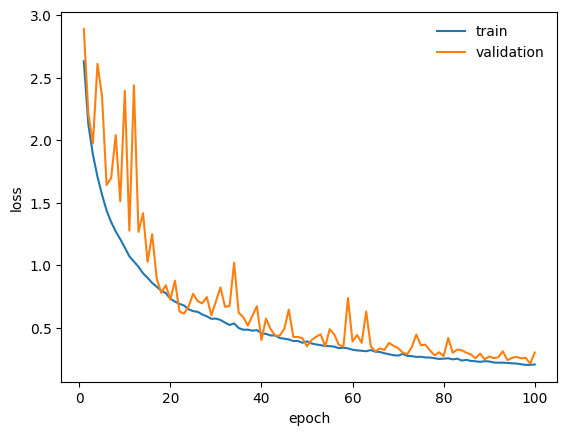

In [110]:
plt.plot(range(1, net.trained_epochs+1), net.train_loss_history)
plt.plot(range(1, net.trained_epochs+1), net.val_loss_history)
plt.legend(['train','validation'], frameon=False)
plt.ylabel('loss')
plt.xlabel('epoch')

  0%|          | 0/177 [00:00<?, ?it/s]


TypeError: unsupported operand type(s) for +: 'Tensor' and 'str'